# BlemishBot

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO

import tensorflow as tf
from keras.src.applications.resnet import preprocess_input

## Load the models

In [38]:
# Load YuNet face detection model
IMG_SIZE = 320
yunet_path = 'models/face_detection_yunet_2023mar.onnx'
yunet_face_detector = cv2.FaceDetectorYN_create(yunet_path, "", (IMG_SIZE, IMG_SIZE), score_threshold=0.5)

# Load the YOLOv8 acne detection model
yolo_path = 'models/acne_model.pt'
yolo_acne_model = YOLO(yolo_path)

# Load classification model
resnet_model = tf.keras.models.load_model('models/best.keras')


(-0.5, 352.5, 469.5, -0.5)

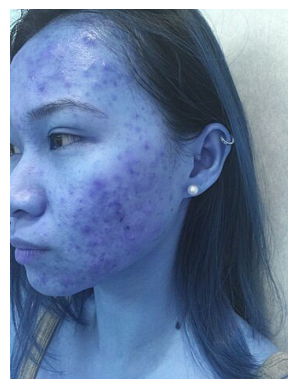

In [39]:
# test_image_path = 'detection_test.webp'
test_image_path = 'sample_inputs/detection_test.jpeg'
test_image = cv2.imread(test_image_path)

plt.imshow(test_image)
plt.axis('off')


## Prepare Image
- Initializes an image from an image_path string
- Returns the RGB image

In [40]:
def prepare_image(image_path):
  image = cv2.imread(image_path)
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Create a square padding
  h, w = image.shape[:2]
  new_size = max(h, w)
  
  padded_image = np.full((new_size, new_size, 3), (0, 0, 0), dtype=np.uint8)

  # Calculate the position to place the original image
  x_offset = (new_size - w) // 2
  y_offset = (new_size - h) // 2

  # Place the original image in the center
  padded_image[y_offset:y_offset + h, x_offset:x_offset + w] = image

  return padded_image

(-0.5, 469.5, 469.5, -0.5)

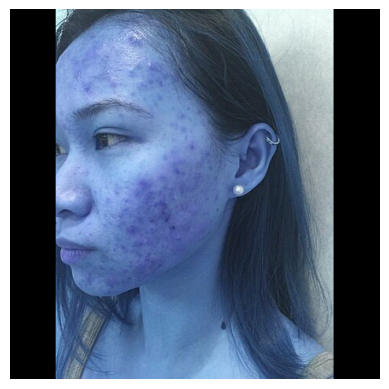

In [41]:
test_image = prepare_image(test_image_path)
plt.imshow(test_image)
plt.axis('off')

## Face detection
- Resize an image for the YuNet model
- Check if only one face is detected
- Returns a cropped image, where the face is isolated from the background

In [42]:
def face_detection_crop(image):
  # resize image
  resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

  # detect face with YuNet
  faces = yunet_face_detector.detect(resized_image)
  
  # assert that faces were detected
  if faces[1] is None:
    print("No face detected.")
    return None
  
  # assert that only one face is detected
  elif len(faces[1]) > 1:
    print("There can only be one face in the image")
    return None
  
  # crop the face
  for face in faces[1]:
    x,y,w,h = int(face[0]), int(face[1]), int(face[2]), int(face[3])

    # ensure boundary boxes are within the image dimensions
    x = max(0, x)
    y = max(0, y)
    w = min(w, IMG_SIZE - x)
    h = min(h, IMG_SIZE - y)

    cropped_image = resized_image[y:y+h, x:x+w]

    return cropped_image


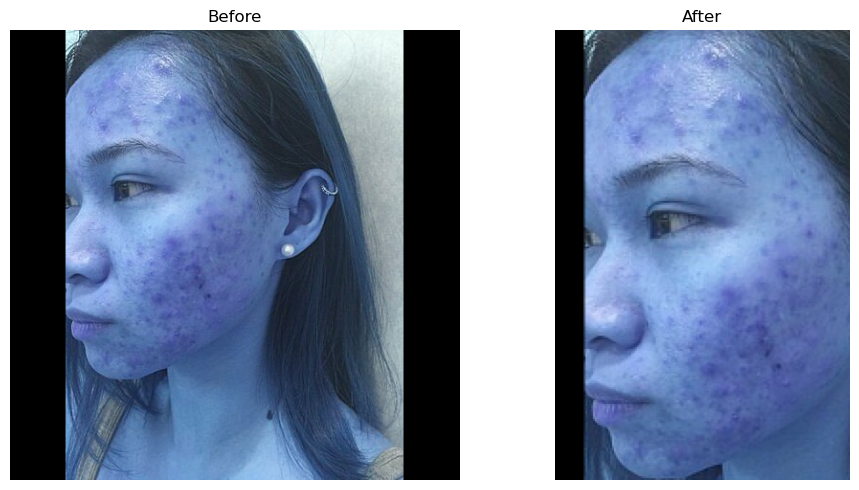

In [43]:
# testing face_detection_crop function
new_test_image = face_detection_crop(test_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(test_image)
axs[0].set_title('Before')
axs[0].axis('off')

axs[1].imshow(new_test_image)
axs[1].set_title('After')
axs[1].axis('off')

plt.tight_layout()


## Acne detection
- detect acne regions
- return acne regions

In [44]:
def acne_detection(image):
  results = yolo_acne_model.predict(image, conf=0.01, iou=0.3, agnostic_nms=True)

  h,w = image.shape[:2]

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  outputs = []
  offset = 50
  for result in results:
    for box in result.boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])
      x1-=offset
      x1 = max(0, x1)

      x2+=offset
      x2 = min(x2, w)

      y1-=offset
      y1 = max(0, y1)

      y2+=offset
      y2 = min(y2, h)

      acne_region = image[y1:y2, x1:x2] 
      # acne_region = sr_model.predict(acne_region)
      # acne_region = np.array(acne_region)

      acne_region = cv2.resize(acne_region, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

      outputs.append(acne_region)

  return outputs


In [45]:
def acne_detection_rect(image):
  results = yolo_acne_model.predict(image, conf=0.01, iou=0.3, max_det=10, agnostic_nms=True)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  offset = 0
  for result in results:
    for box in result.boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])
      label = int(box.cls)
      confidence = float(box.conf)

      x1-=offset
      x2+=offset
      y1-=offset
      y2+=offset

      label_text = f"{yolo_acne_model.names[label]}: {confidence:.2f}"
      
      cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
      cv2.putText(image, label_text, (x1, y1-5), cv2.FONT_HERSHEY_PLAIN, 0.8, (0, 0, 255), 1)

  return image


0: 320x224 10 Acnes, 20.7ms
Speed: 1.0ms preprocess, 20.7ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 224)


(-0.5, 154.5, 236.5, -0.5)

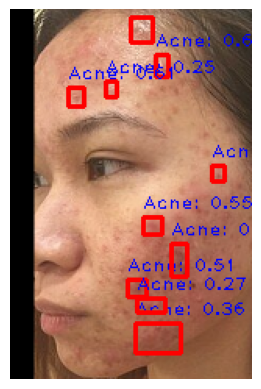

In [46]:
result = acne_detection_rect(new_test_image)
plt.imshow(result)
plt.axis('off')


0: 320x224 10 Acnes, 16.7ms
Speed: 2.4ms preprocess, 16.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 224)


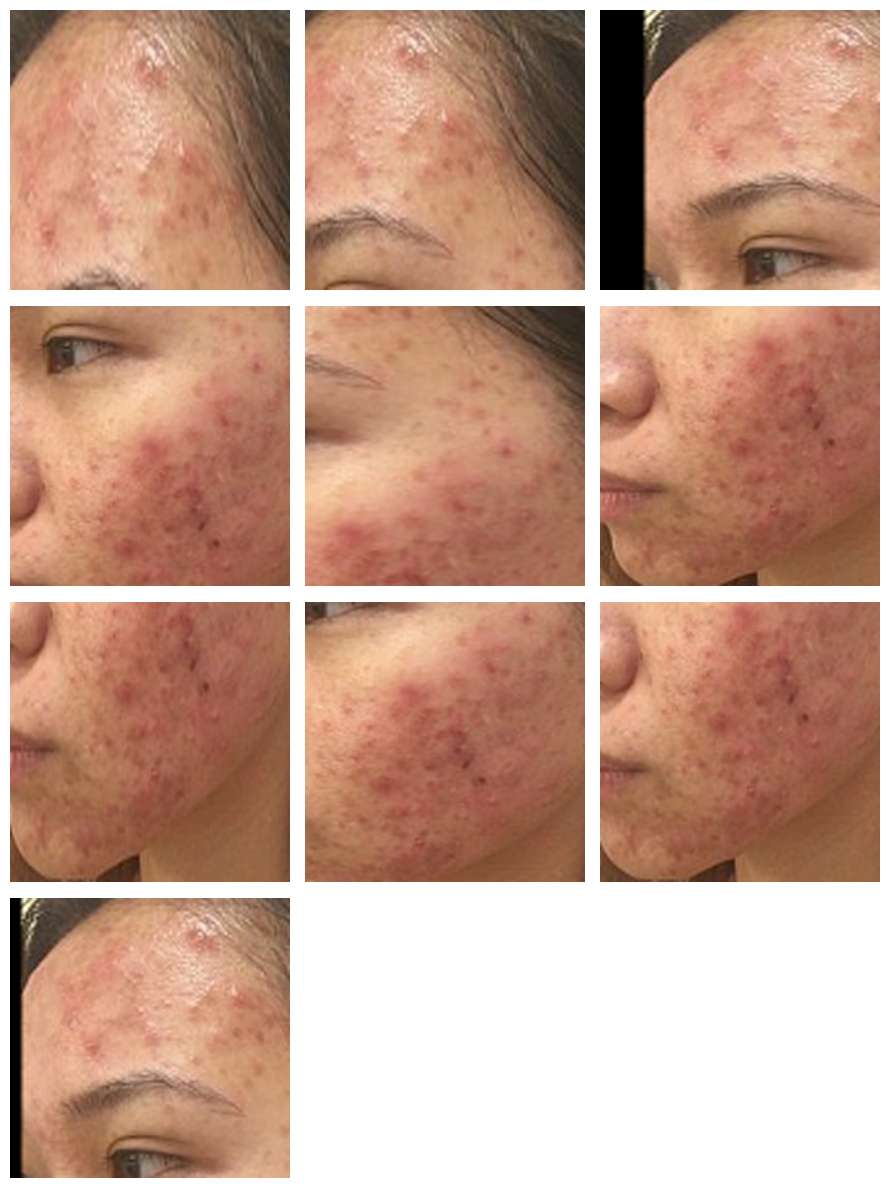

In [47]:
# Usage
outputs = acne_detection(new_test_image)
k = 0

nrows = int(len(outputs)/3) + 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(9, 3*nrows))

for i in range(0, nrows):
  for j in range(0, ncols):
    if k < len(outputs):
      axs[i][j].imshow(outputs[k])
      axs[i][j].axis('off')
      k+=1
    else:
      axs[i][j].axis('off')

plt.tight_layout()

## Acne Classification

In [48]:
def classify_acne(acne_regions):
  targets = ['cystic', 'nodule', 'papule', 'pustule']

  predictions = []
  for region in acne_regions:
    region = preprocess_input(region) # Apply Resnet preprocessing
    region = np.expand_dims(region, axis=0) # Expand dimensions to fit resnet input shape

    probabilities = resnet_model.predict(region)
    acne_type_index = np.argmax(probabilities)
    acne_type = targets[acne_type_index]

    predictions.append(acne_type)

  return predictions

In [49]:
predictions = classify_acne(outputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [50]:
for prediction in predictions:
  print(prediction)

cystic
pustule
cystic
pustule
pustule
pustule
pustule
pustule
pustule
pustule


# New YOLOv8 Model

In [51]:
yolo_path = 'models/best.pt'
yolo_acne_model = YOLO(yolo_path)

(-0.5, 352.5, 469.5, -0.5)

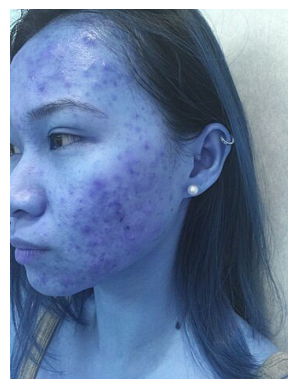

In [52]:
test_image = cv2.imread(test_image_path)
plt.imshow(test_image)
plt.axis('off')

(-0.5, 154.5, 236.5, -0.5)

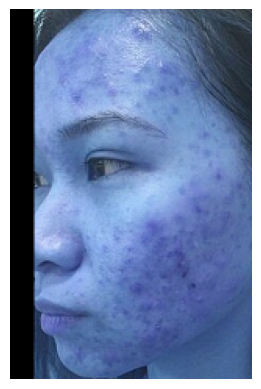

In [53]:
test_image = prepare_image(test_image_path)
test_image = face_detection_crop(test_image)
plt.imshow(test_image)
plt.axis('off')


0: 320x224 1 Nodule, 8 Papuless, 1 Pustule, 19.6ms
Speed: 0.6ms preprocess, 19.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 224)


(-0.5, 154.5, 236.5, -0.5)

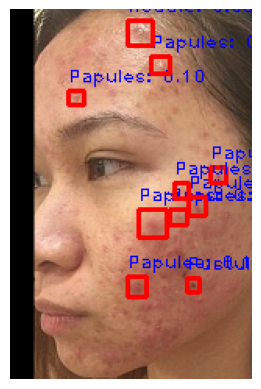

In [54]:
test_image = acne_detection_rect(test_image)
plt.imshow(test_image)
plt.axis('off')
